# Marketing Analytics

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas import Series
from statsmodels.tsa.stattools import acf
from sklearn.linear_model import LinearRegression
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## Data Preparation

### Task 1. Give an overview of our channels and how they contribute to user acquisition.

Two datasets were provided to assess the relationship between tv campagins and user acquisition across channels. One dataset contained information on tv-spending campaign dates (df2), while the other included dates of user acquisition with 4 interactive marketing channels prior to user acquisition (df1):

* `cpc`: cost-per-click marketing channel
* `organic`: organic marketing channel
* `affiliate`: affiliate marketing channel
* `social`: social marketing chanel

As part of data preparation, I first reviewed the data's structure and attributes. I checked for missings, but there was not much to be done to prepare this data. Often I would also normalize the data, but because there is such low variability in the data, I did not expect normalization to change results. For confirmation, I later compared the  distribution of each channel, which is already quite normalized.

In [2]:
# Load user-signup as df1 
df1 = pd.read_csv("/Users/wiseer85/Desktop/Case/user_signup_data.csv")
df1.head()

,userid,cpc,organic,affiliate,social,signup_date
0,e0912256-b48a-45c0-afec-23350d341abd,1,0,0,1,2017-02-01
1,321c18f1-c58e-488d-a60a-462dfc9d38aa,1,0,1,0,2017-01-10
2,3d03c163-d14b-49da-873a-a54cc3b400e3,0,0,1,1,2017-03-24
3,3acb5a84-4375-405b-9a8b-bfb8979ab9bc,1,0,0,0,2017-03-06
4,1b488764-6874-4483-8e70-815feb07b154,1,0,0,0,2017-03-03


In [3]:
# Load tv_campaigns as df2
df2 = pd.read_csv("/Users/wiseer85/Desktop/Case/tv_campaigns.csv")
df2.head()

,date,campaign
0,2017-01-24,tv campaign
1,2017-02-26,tv campaign
2,2017-03-26,tv campaign
3,2017-03-05,tv campaign
4,2017-03-14,tv campaign


## Data Exploration and Visualization

For this task, my initial focus is the impact of tv spending campaigns on user acquisitions. To estimate impact, I first observed the continuous attributes' descriptive stats. The mean of each attribute (or the share of acquisitions associated with respective multichannel attributes) provides a first look into which of the channels are more highly associated with user acquisition. 

As I'm also interested in the relationship between tv campaigns and other channels, I further considered a few question of interest: 

### 1. Which of the channels had the strongest relationship to user acquisition? 

From the descriptive statistics below, majority of user acquisition occured through the `affiliate` and `social` channels (78% and 60%), whereas `cpc` and `organic` channels appear to have a weak relationship with user acquisition (33% and 10%) are are expected to contribute least to user acquisition.

### 1.1. How many of these are unique channels versus mutichannel attributes?    

Only 26% of acquisitions are unique. 

In [4]:
# Add column for tv spending campaign
df1['tv'] = df1['signup_date'].isin(df2['date']).astype(int)

In [5]:
# Add column for the sum of the different channels
df1['multi'] = df1['cpc'] + df1['organic'] + df1['affiliate'] + df1['social']

In [6]:
# Create a dummy for unique channels
df1['unique'] = np.where(df1['multi']==1, 1, 0)
df1.describe()

,cpc,organic,affiliate,social,tv,multi,unique
count,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.00000,5000.000000
mean,0.331600,0.103800,0.779400,0.59700,0.110000,1.81180,0.259400
std,0.470835,0.305031,0.414693,0.49055,0.312921,0.54336,0.438349
min,0.000000,0.000000,0.000000,0.00000,0.000000,1.00000,0.000000
25%,0.000000,0.000000,1.000000,0.00000,0.000000,1.00000,0.000000
50%,0.000000,0.000000,1.000000,1.00000,0.000000,2.00000,0.000000
75%,1.000000,0.000000,1.000000,1.00000,0.000000,2.00000,1.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,3.00000,1.000000


### 2. What share of user acquisations is associated with tv campaigns? Does this association differ across channels?

To answer these questions, I first split the datasets into two groups: a) acquisitions on tv campaigns dates and 2) acquisitions on non-tv campaign dates. I summarized frequencies of acquisitions by channel (df). Next, I calculated the ratio (`%TV`) of acquisitions associated with a tv campaign dates or not. In addition, I calculated the share of `unique` attributes. 

Whereas `TV` measures the ratio of attributes signed up on a TV campaign date to those that were not, `unique` measures the % of total acquisitions (n=5000) that were unique versus multichannel attributes. Because channels are not exculsive (as with the unique score), I took a ratio instead of a percentage in order to isolating the effect of tv across channels.  

The second table shows the count of acquisitions grouped by channels. Overall tv campaigns contribute roughly 10% of acquisitions across channels. As the impact of tv campaigns do not differentiate substantively across channels, this suggests that user acquisition can be increased by tv campaigns, although the size of impact is moderated by the relationship of that campaign to respective channels.

In [7]:
# Split dataframes by dates that correspond to tv-spending campaigns 
df_tv = df1.loc[df1['signup_date'].isin(df2['date'])]
df_notv = df1.loc[~df1['signup_date'].isin(df2['date'])]

In [8]:
# Count user acquisition by channel 
df_tv = pd.melt(df_tv[['cpc','organic','affiliate','social']], var_name="channel", value_name="TV").groupby(['channel']).sum().reset_index()
df_notv = pd.melt(df_notv[['cpc','organic','affiliate','social','unique']], var_name="channel", value_name="NoTV").groupby(['channel']).sum().reset_index()

In [9]:
# Count share of unique channels
df_uni = df1.loc[df1['unique']]
df_uni = pd.melt(df_uni[['cpc','organic','affiliate','social']], var_name="channel", value_name="unique").groupby(['channel']).sum().reset_index()

In [10]:
# Merge dataframes as one
df = df_tv.merge(df_notv,on='channel').merge(df_uni,on='channel')

In [11]:
# Add column for share of channel that is unique 
df['%U'] = df['unique'] / 5000

In [12]:
# Add column for share of channels that are associated with TV campaign 
df['%TV'] = df['TV'] / df['NoTV'] 
df

,channel,TV,NoTV,unique,%U,%TV
0,affiliate,421,3476,1297,0.2594,0.121116
1,cpc,191,1467,5000,1.0000,0.130198
2,organic,59,460,0,0.0000,0.128261
3,social,323,2662,3703,0.7406,0.121337


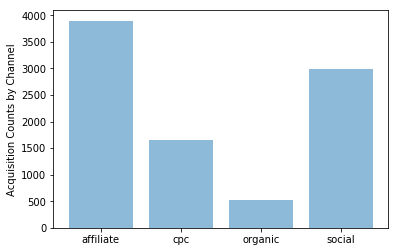

In [13]:
# Add column for channel total
df['chncnt'] = df['TV'] + df['NoTV'] 

# Plot channel counts
objects = df['channel']
y_pos = np.arange(len(objects))
performance = df['chncnt']
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Acquisition Counts by Channel')
 
plt.show()

### 3) Is there a lag/residual effect or do we see changes over time?

To answer this question, I reorganized my data as time-series data (y = acquisitions per diem). As shown in figure from df3, there is an increase in acquisitions overall on days that tv campaigns were made. Because there doesn't appear to be any lag-effect, it seems that tv campaigns are more the last push for people to sign up. I could do further analysis to compare average changes over adjusted periods of time, but at this point, we do not know the counterfactual (i.e would these users have signed up if there was no tv campaign?).

In [14]:
# Count user acquisition by date  
df3 = df1.groupby(['signup_date', 'tv']).size().reset_index(name='total')
df3.head()

,signup_date,tv,total
0,2017-01-01,1,67
1,2017-01-02,0,56
2,2017-01-03,0,47
3,2017-01-04,0,54
4,2017-01-05,0,50


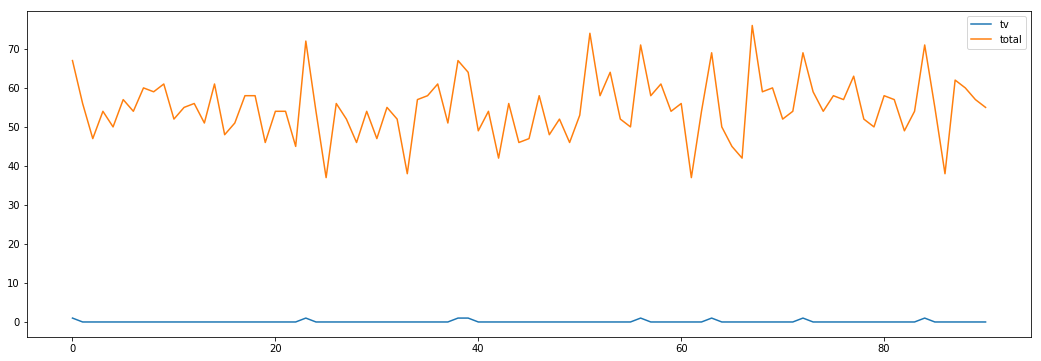

In [15]:
# Plot total user acquisition beside tv campaigns
df3.plot(figsize=(18, 6))
plt.show()

### 4) To what extent do the channels correlate user acquisitions?

To answer this question, I similarly reorganized my covariate data (x = total acquisitions by channel per diem). As shown in figure from df4, all of the channels are relatively distributed. `Oganic` and `CPC` channels have the greatest spread and least correlation with the other channels. In contrast, there is a positive relationship between `affiliate`and `social`, which suggests correlation data points (i.e. multichannel touchpoint). This is further supported by looking at the % of `unique` acquisitions.

In [16]:
# Count user acquisition by date and channels
df4 = df1.groupby(['signup_date'])['cpc','organic','affiliate','social'].sum()
df4 = df4.reset_index()
df4.head()

,signup_date,cpc,organic,affiliate,social
0,2017-01-01,24,10,45,36
1,2017-01-02,17,3,46,31
2,2017-01-03,11,6,37,26
3,2017-01-04,20,5,39,33
4,2017-01-05,14,6,36,30


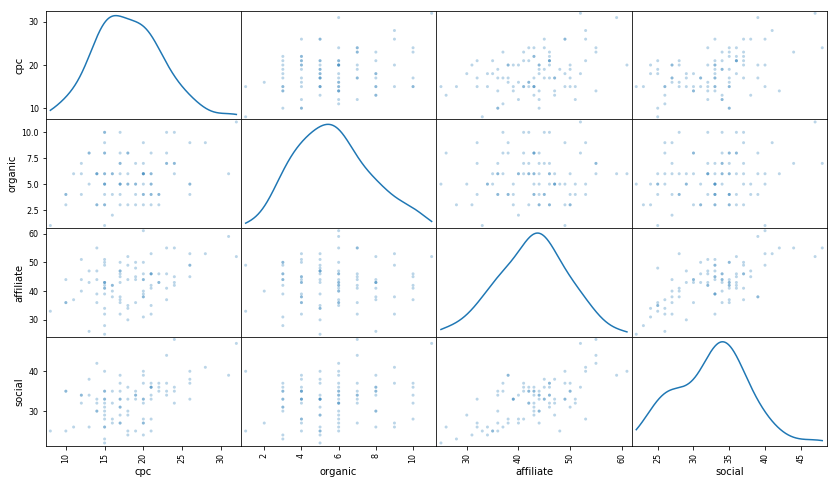

In [17]:
# Produce a scatter matrix for each pair of features in the data
pd.plotting.scatter_matrix(df4, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

In [18]:
df5 = pd.merge(df3, df4,  how='left', on='signup_date')
df5.head()

,signup_date,tv,total,cpc,organic,affiliate,social
0,2017-01-01,1,67,24,10,45,36
1,2017-01-02,0,56,17,3,46,31
2,2017-01-03,0,47,11,6,37,26
3,2017-01-04,0,54,20,5,39,33
4,2017-01-05,0,50,14,6,36,30


In [19]:
df5.head()

,signup_date,tv,total,cpc,organic,affiliate,social
0,2017-01-01,1,67,24,10,45,36
1,2017-01-02,0,56,17,3,46,31
2,2017-01-03,0,47,11,6,37,26
3,2017-01-04,0,54,20,5,39,33
4,2017-01-05,0,50,14,6,36,30


## Prediction

### Task 2. Estimate the impact of doubling TV spending

After merging dataframes by acquisition dates, we can estimate the average difference in user acquisition on dates aired or not in order to isolate the impact of tv campaigns. This is done using a simple linear regression, where y = `total` acquisitions and x according to user aquisition date (df3). 

On the one hand, this is a straight forward model, but it calculates a naive, black-box estimate, where the effect represents not only the independent tv effect, but also any confounding effects from the channel access points. Alternatively, a multivariate regression would show how much of the effect from M1 is explained by the channels (see further steps).

Once I have calculated the slope (m = 15 users per diem), I can calculate the predicted y on days tv campaigns were run or not (y-intercept = 53). This suggests that 120 of the 5000 acquisitions (i.e. 15 users per diem for 8 tv campaigns) were attributed to tv campaigns (2% increase). If tv campaigns were doubled (i.e. 16 tv campaigns), this would hypothetically increase user acquisition by an additional 2%, estimating a total of 5120 user acquisitions instead of 5000.

However, this model is based on linear assumptions. Therefore, I have to ask: 
* How constant are my assumptions in reality (i.e. are there are season or annual changes that might influence the predicted return over time?) 
* How complete is this information (i.e. does it include information from all devices or log-ins) or is there concern for omitted variable bias or confounding variables?

In [20]:
# Fit linear regression model
y = np.array(df3['total'])
X = np.array(df3.drop(['total','signup_date'], axis=1, inplace=False))

model = LinearRegression(fit_intercept=True)
model.fit(X, y)

print("Model slope:", model.coef_[0])
print("Model intercept:", model.intercept_)
print("Model R2 score:", model.score(X,y))

Model slope: 15.1355421686747
Model intercept: 53.614457831325296
Model R2 score: 0.29856128709671115


In [21]:
# Predict y
xfit = np.linspace(0,1)
yfit = model.predict(xfit[:, np.newaxis])
yfit

array([53.61445783, 53.92334645, 54.23223506, 54.54112368, 54.85001229,
       55.15890091, 55.46778953, 55.77667814, 56.08556676, 56.39445537,
       56.70334399, 57.0122326 , 57.32112122, 57.63000984, 57.93889845,
       58.24778707, 58.55667568, 58.8655643 , 59.17445291, 59.48334153,
       59.79223015, 60.10111876, 60.41000738, 60.71889599, 61.02778461,
       61.33667322, 61.64556184, 61.95445045, 62.26333907, 62.57222769,
       62.8811163 , 63.19000492, 63.49889353, 63.80778215, 64.11667076,
       64.42555938, 64.734448  , 65.04333661, 65.35222523, 65.66111384,
       65.97000246, 66.27889107, 66.58777969, 66.89666831, 67.20555692,
       67.51444554, 67.82333415, 68.13222277, 68.44111138, 68.75      ])

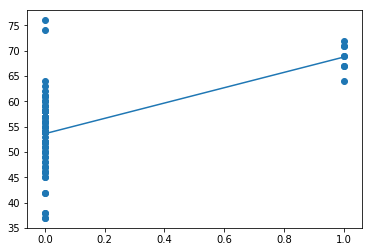

In [22]:
# Plot regression values
plt.scatter(X, y)
plt.plot(xfit,yfit)
plt.show()

### Task 3. Make assumptions for the channel touchpoint cost and give recommendations how to change the budget allocation to maximize user acquisition with a constant budget

See presentation

### Next Steps
* change figure df3 x-axis to dates to show period changes (ie compare seasonal or annual trends)
* add lines for channels to compare spikes across channels
* compare average acquisition 5 day +/- tv campaigns
* use demographic information for segmentation profiles using supervised classification
* M2 - multivariate model with channel covariates OR separate models for each channel if (n>25)
* include a graph of regression fitted over data plot with confidence intervals
* M3 - multivariate model with interaction effect between tv campaign and channels
* M4 - time series model
* Use predictive analysis to optimize budget allocation (with weights for unique acquisitions)